In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, precision_recall_curve, recall_score, f1_score, auc, roc_auc_score, plot_roc_curve
from sklearn.model_selection import KFold
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier
sys.path.append('C:\\Users\\chery\\OneDrive\\Documents\\UW Bothell MSEE\\Predictive Learning\\BSEE_520_FP')
from utils.baseML import BaseML
from datetime import datetime


In [6]:
class Seattle_Police_ML(BaseML):
    def dayDifference(self, fdate, ldate):
        delta = ldate - fdate
        return(delta)

    def transform_times(self):
        self.df["at_scene_datetime"] = self.df.apply(lambda x: x.At_Scene_Date + "T" + x.At_Scene_Time, axis=1)
        self.df['at_scene_temp'] = self.df.at_scene_datetime.apply(lambda x: datetime.fromisoformat(x))
        self.df.Event_Clearance_Date.fillna("2021-05-13", inplace=True)
        self.df.Event_Clearance_Time.fillna("00:00:00", inplace=True)
        #self.df[["Event_Clearance_Date", "Event_Clearance_Time"]] = self.df[["Event_Clearance_Date", "Event_Clearance_Time"]].astype(str)
        #print(spir.df.Event_Clearance_Date.dtype)
        self.df["event_clear_datetime"] = self.df.apply(lambda x: x.Event_Clearance_Date + "T" + x.Event_Clearance_Time, axis=1)
        self.df['event_clear_temp'] = self.df.event_clear_datetime.apply(lambda x: datetime.fromisoformat(x))
        self.df['time_at_scene'] = self.df.apply(lambda x: pd.to_timedelta(self.dayDifference(x["at_scene_temp"], x["event_clear_temp"])), axis = 1)
        self.df.drop(["At_Scene_Date","At_Scene_Time", "Event_Clearance_Date", "Event_Clearance_Time"], axis = 1, inplace = True)
        #self.df.drop(self.df[self.df['Schedule_to_appt_days'] < 0].index, inplace = True)
        #self.df.dropna(inplace=True)
        print(self.df.sample(3))

    def simplify_times(self):
        bins = (
            pd.Timedelta(minutes = 0),
            pd.Timedelta(minutes = 30),
            pd.Timedelta(minutes = 60),
            pd.Timedelta(hours = 4),
            pd.Timedelta(hours = 8),
            pd.Timedelta(hours = 12),
            pd.Timedelta(days = 1),
            pd.Timedelta(days = 36500)
        )

        labels = ['< 30min', '30-60min','1-4hrs', '4-8hrs','8-12hrs','12-24hrs', '24hrs+']

        return pd.cut(self.df['time_at_scene'], bins, labels = labels)
    

    def encode_features(self):
        features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
        df_combined = pd.concat([df_train[features], df_test[features]])
        
        for feature in features:
            le = preprocessing.LabelEncoder()
            le = le.fit(df_combined[feature])
            df_train[feature] = le.transform(df_train[feature])
            df_test[feature] = le.transform(df_test[feature])
        return df_train, df_test
        
        data_train, data_test = encode_features(data_train, data_test)
        data_train.head()

    def normalize_features(self):
        scaler = preprocessing.StandardScaler().fit(self.df)
        df_scaled = scaler.transform(self.df)
        self.df = pd.DataFrame(df_scaled, columns = self.df.columns, dtype= 'int64')

        

In [7]:
spir = Seattle_Police_ML("Seattle_Police_Response_Scene_Time_Only_2.csv")
print(spir.df.Event_Clearance_Date.dtype)
spir.df.dropna(subset=['Event Clearance Code', 'Census Tract', 'Event_Clearance_Date', 'Event_Clearance_Time'], inplace=True)
spir.transform_times()

C:\Users\chery\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
object
       CAD CDW ID  CAD Event Number  General Offense Number  \
109156    1624429       15000422571              2015422571   
66395     1480983       15000238766              2015238766   
1975      1261269       11000024464               201124464   

        Event Clearance Code Event Clearance Description  \
109156                 220.0  CRISIS COMPLAINT - GENERAL   
66395                   40.0             ASSAULTS, OTHER   
1975                   130.0        PROPERTY DESTRUCTION   

       Event Clearance SubGroup Event Clearance Group  \
109156              CRISIS CALL     BEHAVIORAL HEALTH   
66395                  ASSAULTS              ASSAULTS   
1975            PROPERTY DAMAGE       PROPERTY DAMAGE   

     

In [11]:
spir.df['event_year'] = spir.df.event_clear_temp.apply(lambda x: x.year)

In [12]:
spir.df.to_csv("SPIR_no_NaN.csv")

In [28]:
print(spir.df.dtypes)
from sklearn.cluster import KMeans
event_clear_group = spir.df['Event Clearance Group'].astype('category')
districts = spir.df['District/Sector'].astype('category')
print(event_clear_group.dtypes)
print(districts.dtypes)
df = pd.concat([spir.df['Longitude'], spir.df['Latitude']], axis=1)

CAD CDW ID                              object
CAD Event Number                         int64
General Offense Number                   int64
Event Clearance Code                   float64
Event Clearance Description             object
Event Clearance SubGroup                object
Event Clearance Group                   object
Hundred Block Location                  object
District/Sector                         object
Zone/Beat                               object
Census Tract                           float64
Longitude                              float64
Latitude                               float64
Incident Location                       object
Initial Type Description                object
Initial Type Subgroup                   object
Initial Type Group                      object
at_scene_datetime                       object
event_clear_datetime                    object
time_at_scene                  timedelta64[ns]
dtype: object
category
category


In [25]:
print(df.dtypes)
print(df['Event Clearance Group'].value_counts())
print(df['Event Clearance Group'].values)
#print(spir.df.shape)

Event Clearance Group           category
time_at_scene            timedelta64[ns]
dtype: object
SUSPICIOUS CIRCUMSTANCES                 28224
DISTURBANCES                             26311
TRAFFIC RELATED CALLS                    22720
MOTOR VEHICLE COLLISION INVESTIGATION    21865
BURGLARY                                 14003
CAR PROWL                                13313
OTHER PROPERTY                            9792
AUTO THEFTS                               8684
TRESPASS                                  7996
ASSAULTS                                  7746
BEHAVIORAL HEALTH                         6716
PROPERTY DAMAGE                           6489
SHOPLIFTING                               6200
ACCIDENT INVESTIGATION                    5667
NUISANCE, MISCHIEF                        4914
THREATS, HARASSMENT                       4523
NARCOTICS COMPLAINTS                      4424
FRAUD CALLS                               4302
PROPERTY - MISSING, FOUND                 4242
ARREST     

In [29]:
clf = KMeans(43)
labels = clf.fit_predict(df)

<AxesSubplot:xlabel='District/Sector', ylabel='count'>

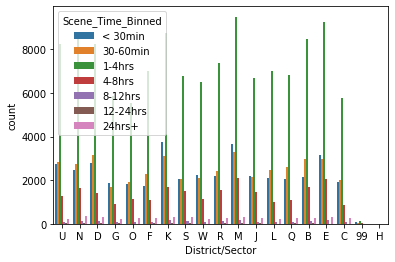

In [4]:
spir.df["Scene_Time_Binned"] = spir.simplify_times()
#print(spir.df.time_at_scene[0].seconds)
#spir.df.sample(3)
spir.df.to_csv("SPIR_updated.csv")
sns.countplot(x="District/Sector", hue="Scene_Time_Binned", data=spir.df)


In [ ]:
spir.df.dropna(axis=0, inplace=True)
spir.create_train_and_test_df("Scene_Time_Binned", ["Scene_Time_Binned", "CAD CDW ID", "CAD Event Number", "General Offense Number", "time_at_scene"])
print(spir.df.shape)

In [7]:
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression, ClassificationTree, DecisionListClassifier
#spir.df["time_at_scene"] = spir.df["time_at_scene"].to_string()
#print(spir.df.time_at_scene.dtypes)
ebm = ExplainableBoostingClassifier(random_state=1, n_jobs=-1)
ebm.fit(spir.X_all, spir.y_all)
ebm_global = ebm.explain_global(name="EBM")
show(ebm_global)

C:\Users\chery\AppData\Local\Programs\Python\Python39\lib\site-packages\interpret\glassbox\ebm\ebm.py:789: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")
C:\Users\chery\AppData\Local\Programs\Python\Python39\lib\site-packages\interpret\glassbox\ebm\ebm.py:792: UserWarning: Detected multiclass problem: forcing interactions to 0
  warn("Detected multiclass problem: forcing interactions to 0")
